# Fine-tuning Stable Diffusion with DreamBooth

In this notebook you'll learn how to personalise Stable Diffusion by fine-tuning it on just a handful of your own images! To do so, we'll use a technique called [_DreamBooth_](https://arxiv.org/abs/2208.12242), which allows one to implant a subject (e.g. your pet or face) into the output domain of the model such that it can be synthesized with a unique identifier in the prompt.

Let's dive in!

## What you will learn

By the end of this notebook, you will know:

* The core intuitions behind the DreamBooth approach to fine-tuning
* How to use 🤗 Diffusers to fine-tune Stable Diffusion on your own images
* How to push your fine-tuned diffusion model to the Hugging Face Hub

## Prerequisites

Before diving into this notebook, you should do the following steps first:

* Read the Unit 1 README that contains all the information
* Develop an intuition for how diffusion models work by first working through the NB

## What is DreamBooth?

## Step 1: Setup

If you're running this notebook on Google Colab or Kaggle, run the cell below to install the required libraries:

In [ ]:
%pip install -qq diffusers transformers bitsandbytes accelerate ftfy datasets

In [26]:
!rm -rf dreambooth-concept/

Something about access token and logging in or save until push to hub?

## Step 2: Create a dataset and upload it to the Hub

The first thing you need to do is create a dataset of images and upload it to the Hugging Face Hub:

* You'll need around **10-20 images of the subject** that you wish to implant in the model
* For best results, we recommend using images of your subject from **different angles and perspectives** 

Once you've collected your images, you can upload them to the Hub by using the UI to drag and drop your images. See [this guide](https://huggingface.co/docs/datasets/upload_dataset#upload-with-the-hub-ui) for more details, or watch the video below:

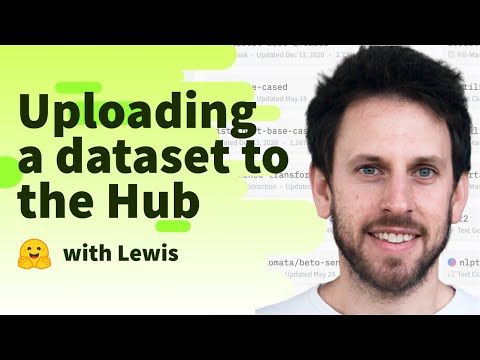

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo("HaN6qCr_Afc")

Once you've created your dataset, you can download it by using the `load_dataset()` function as follows:

In [2]:
from datasets import load_dataset

dataset_id = "lewtun/cat-toy" # CHANGE THIS TO YOUR {hub_username}/{dataset_id}
dataset = load_dataset(dataset_id, split="train")
dataset

Using custom data configuration lewtun--cat-toy-27899f640017ae16
Found cached dataset parquet (/home/lewis_huggingface_co/.cache/huggingface/datasets/lewtun___parquet/lewtun--cat-toy-27899f640017ae16/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image'],
    num_rows: 4
})

Now that we have our dataset, let's define a helper function to view a few of the images:

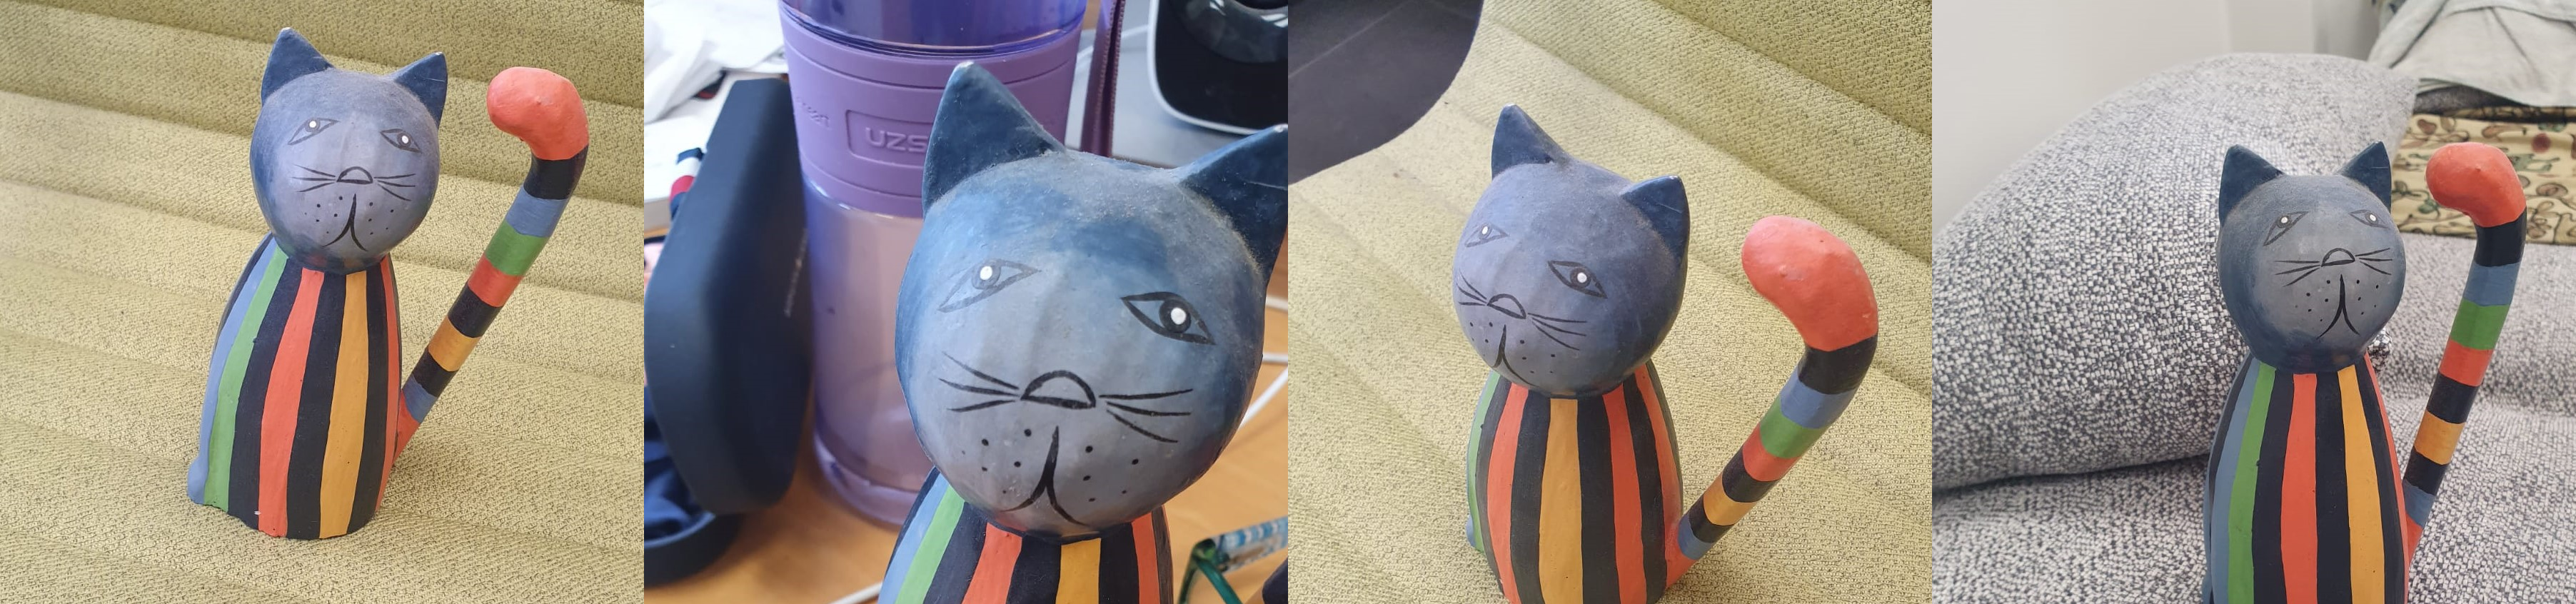

In [4]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(dataset["image"], rows=1, cols=4)

If this looks good, you can move onto the next step - creating a PyTorch dataset for training with DreamBooth.

## Step 3: Create a training dataset

In [5]:
type_of_thing = "toy" # CHANGE THIS ACCORDING TO YOUR SUBJECT
instance_prompt = f"a photo of sks {type_of_thing}"

In [10]:
from torchvision import transforms
from torch.utils.data import Dataset

class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        self.size = size
        self.transforms = transforms.Compose(
                    [
                        transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                        transforms.CenterCrop(size),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5], [0.5]),
                    ]
                )
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids
        return example

In [11]:
from transformers import CLIPTokenizer

model_id = "CompVis/stable-diffusion-v1-4"

tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

In [12]:
train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)

In [13]:
train_dataset[0]

{'instance_images': tensor([[[ 0.0118, -0.0039,  0.0431,  ...,  0.1216,  0.1216,  0.0667],
          [ 0.0118,  0.0353,  0.1059,  ...,  0.1922,  0.1686,  0.2157],
          [ 0.0824,  0.0902,  0.1608,  ...,  0.2157,  0.0902,  0.1451],
          ...,
          [ 0.5843,  0.7098,  0.7020,  ...,  0.4510,  0.5294,  0.4039],
          [ 0.5059,  0.3961,  0.4510,  ...,  0.4275,  0.6863,  0.5686],
          [ 0.8039,  0.5137,  0.5608,  ...,  0.6157,  0.6706,  0.6471]],
 
         [[-0.0431, -0.0588, -0.0118,  ...,  0.0275,  0.0275, -0.0275],
          [-0.0431, -0.0196,  0.0510,  ...,  0.0980,  0.0745,  0.1216],
          [ 0.0275,  0.0353,  0.1059,  ...,  0.1216,  0.0039,  0.0588],
          ...,
          [ 0.5059,  0.6314,  0.6235,  ...,  0.3412,  0.4196,  0.2941],
          [ 0.4275,  0.3176,  0.3725,  ...,  0.3255,  0.5765,  0.4588],
          [ 0.7255,  0.4353,  0.4824,  ...,  0.5059,  0.5608,  0.5373]],
 
         [[-0.3882, -0.3882, -0.3412,  ..., -0.2863, -0.2941, -0.3569],
         

## Step 4: Define a data collator

In [16]:
import torch

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch

## Step 5: Load the components of the Stable Diffusion pipeline

In [17]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPFeatureExtractor, CLIPTextModel

text_encoder = CLIPTextModel.from_pretrained(
    model_id, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    model_id, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    model_id, subfolder="unet"
)
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

## Step 6: Fine-tune the model

In [19]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=model_id,
    resolution=512,
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=5e-06, # IMPORTANT
    max_train_steps=450, # IMPORTANT
    train_batch_size=1,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="no", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="dreambooth-concept",
)

In [27]:
from accelerate import Accelerator
import bitsandbytes as bnb
from torch.utils.data import DataLoader
import math
from tqdm.auto import tqdm
import torch.nn.functional as F
from accelerate.utils import set_seed

from diffusers import PNDMScheduler, StableDiffusionPipeline, DDPMScheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker

def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(
        unet.parameters(),  # only optimize unet
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000
    )

    train_dataloader = DataLoader(
        args.train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)
  
    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()
    
    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        scheduler = PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True, steps_offset=1
            )
        safety_checker = StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker")
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

In [29]:
from accelerate import notebook_launcher

num_of_gpus = torch.cuda.device_count()
notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus)

with torch.no_grad():
    torch.cuda.empty_cache()

Launching training on one GPU.


  0%|          | 0/450 [00:00<?, ?it/s]

## Step 7: Run inference and inspect generations

In [30]:
pipe = StableDiffusionPipeline.from_pretrained(
        args.output_dir,
        torch_dtype=torch.float16,
    ).to("cuda")

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

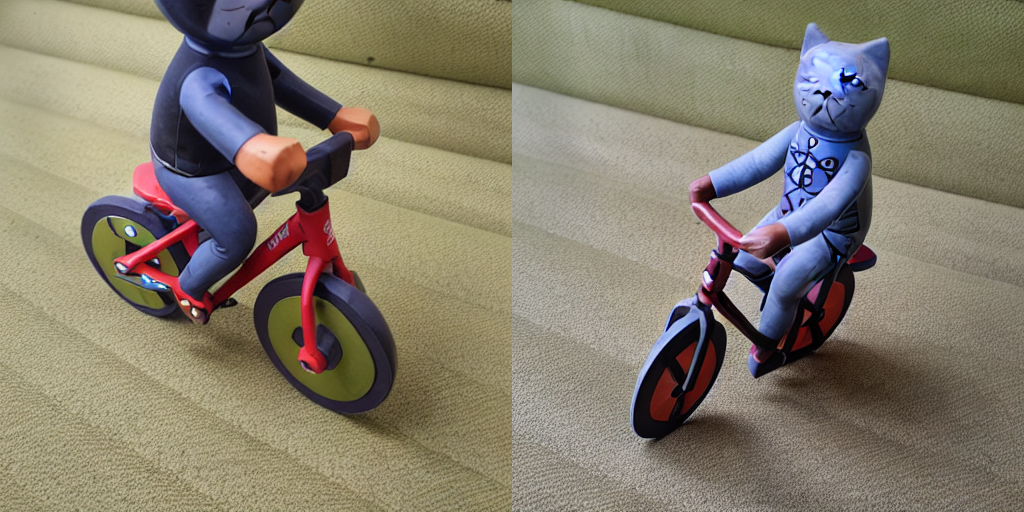

In [34]:
prompt = f"a photo of sks {type_of_thing} riding a bicycle"

num_samples = 1 
num_cols = 2

all_images = [] 
for _ in range(num_cols):
    images = pipe(prompt, num_images_per_prompt=num_samples, guidance_scale=7.5).images
    all_images.extend(images)

image_grid(all_images, num_samples, num_cols)

## Push to Hub

* Add tag!
* Use `huggingface_hub` RepoCard